# LIBRARIES REQUIRED

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier as rcf
from sklearn.tree import DecisionTreeClassifier as dct
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
from catboost import CatBoostClassifier, Pool

In [2]:
SEED = 1972

In [3]:
train = pd.read_csv('train_s3TEQDk.csv')
test = pd.read_csv('test_mSzZ8RL.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


# MISSING VALUES AND TREATMENT

In [5]:
train.isna().sum()
train.isnull().sum() / len(train)

ID                     0.000000
Gender                 0.000000
Age                    0.000000
Region_Code            0.000000
Occupation             0.000000
Channel_Code           0.000000
Vintage                0.000000
Credit_Product         0.119341
Avg_Account_Balance    0.000000
Is_Active              0.000000
Is_Lead                0.000000
dtype: float64

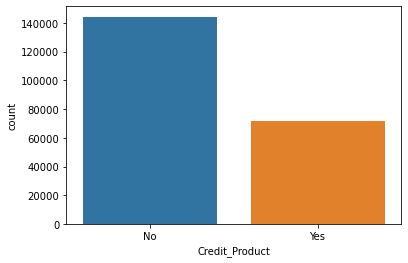

In [6]:
sns.countplot(train['Credit_Product'])

In [7]:
train["Credit_Product"]=train["Credit_Product"].fillna("Unknown")
test["Credit_Product"]=test["Credit_Product"].fillna("Unknown")
#train.dropna(axis='columns', how='any', inplace=True)

#new_data = data.dropna(axis = 0, how ='any')

# OUTLIERS

In [8]:
train=train[(train["Avg_Account_Balance"]<2673000)]

In [9]:
train.Is_Lead.value_counts() / len(train)

0    0.764608
1    0.235392
Name: Is_Lead, dtype: float64

ENCODING 
We will be using CatBoostClassifier as for training the data and later on we will check how it is performing on the test set. Evaluation and Accuracy will be checked for the model. As, we have Categorical Variables to be dealt with so going with CatBoostClassifier will be good enough, as Catboost handles the Categorical features directly, no explicit OHE or encoding scheme is required.

In [10]:
display(train.dtypes)

ID                     object
Gender                 object
Age                     int64
Region_Code            object
Occupation             object
Channel_Code           object
Vintage                 int64
Credit_Product         object
Avg_Account_Balance     int64
Is_Active              object
Is_Lead                 int64
dtype: object

In [11]:
train.drop(columns ='ID',inplace=True)
test.drop(columns ='ID',inplace=True)

In [22]:
#train = encoder.fit_transform(train) 

cat_columns = []
for col in train.select_dtypes('object').columns:
    print(col) 
    cat_columns.append(col)
    #le = LabelEncoder()
    #train[col] = le.fit_transform(train[col])

Gender
Region_Code
Occupation
Channel_Code
Credit_Product
Is_Active


(array([ 5444., 43975., 58617., 44491., 30008., 19739., 12909.,  8784.,
         5491.,  3970.]),
 array([  20790.,  286010.,  551230.,  816450., 1081670., 1346890.,
        1612110., 1877330., 2142550., 2407770., 2672990.]),
 <a list of 10 Patch objects>)

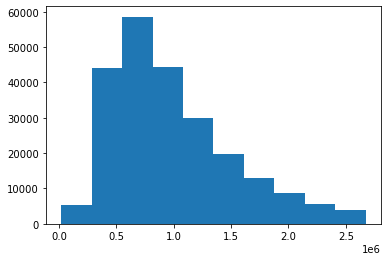

In [13]:
plt.hist(train['Avg_Account_Balance'])

(array([1.0000e+00, 7.0000e+00, 3.9000e+01, 2.9300e+02, 2.2130e+03,
        1.3795e+04, 4.9396e+04, 7.6676e+04, 6.1866e+04, 2.9142e+04]),
 array([ 9.94222738, 10.42787547, 10.91352356, 11.39917164, 11.88481973,
        12.37046782, 12.8561159 , 13.34176399, 13.82741208, 14.31306017,
        14.79870825]),
 <a list of 10 Patch objects>)

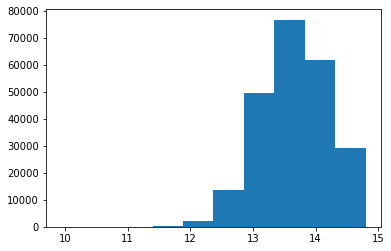

In [14]:
plt.hist(np.log(train['Avg_Account_Balance']))

plt.hist(np.boxcox(train['Avg_Account_Balance']))

(array([3.8000e+01, 1.1410e+03, 1.0678e+04, 3.6882e+04, 5.4175e+04,
        4.9172e+04, 3.5984e+04, 2.3214e+04, 1.4244e+04, 7.9000e+03]),
 array([ 144.18737809,  293.26145358,  442.33552907,  591.40960455,
         740.48368004,  889.55775553, 1038.63183102, 1187.70590651,
        1336.779982  , 1485.85405749, 1634.92813298]),
 <a list of 10 Patch objects>)

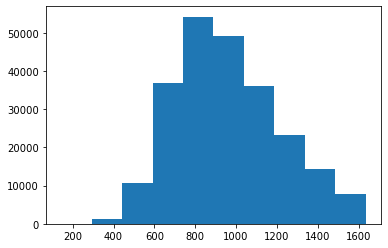

In [15]:
plt.hist(np.sqrt(train['Avg_Account_Balance']))

In [16]:
train['Avg_Account_Balance']=np.sqrt(train['Avg_Account_Balance'])

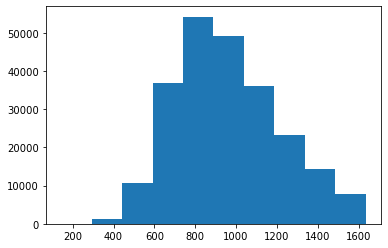

In [17]:
plt.hist(((train['Avg_Account_Balance'])));

In [18]:
Y= train["Is_Lead"]
X=train.drop(["Is_Lead"],axis=1)

In [19]:
X.columns

Index(['Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code', 'Vintage',
       'Credit_Product', 'Avg_Account_Balance', 'Is_Active'],
      dtype='object')

In [23]:
cat_features_index = [i for i,col in enumerate(X.columns) if col in cat_columns]
cat_features_index

[0, 2, 3, 4, 6, 8]

In [32]:
#### MODEL 

#cate_features_index = np.where(trainset.dtypes != float)[0]
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X, Y, train_size=0.85,random_state=SEED)
from catboost import CatBoostClassifier


cat = CatBoostClassifier(eval_metric='Accuracy',
                         use_best_model=True,random_seed=SEED,learning_rate = 0.674 ,iterations = 700,depth = 4,
                         bagging_temperature=3,one_hot_max_size=2)

In [34]:
cat.fit(X1_train,y1_train ,cat_features=cat_features_index,eval_set=(X1_test,y1_test),use_best_model=True)

0:	learn: 0.8480493	test: 0.8477795	best: 0.8477795 (0)	total: 359ms	remaining: 4m 10s
1:	learn: 0.8514714	test: 0.8526060	best: 0.8526060 (1)	total: 442ms	remaining: 2m 34s
2:	learn: 0.8575093	test: 0.8591461	best: 0.8591461 (2)	total: 538ms	remaining: 2m 4s
3:	learn: 0.8592381	test: 0.8601742	best: 0.8601742 (3)	total: 654ms	remaining: 1m 53s
4:	learn: 0.8599840	test: 0.8616022	best: 0.8616022 (4)	total: 760ms	remaining: 1m 45s
5:	learn: 0.8600243	test: 0.8624875	best: 0.8624875 (5)	total: 853ms	remaining: 1m 38s
6:	learn: 0.8599386	test: 0.8617735	best: 0.8624875 (5)	total: 947ms	remaining: 1m 33s
7:	learn: 0.8603116	test: 0.8619449	best: 0.8624875 (5)	total: 1.05s	remaining: 1m 30s
8:	learn: 0.8606795	test: 0.8624304	best: 0.8624875 (5)	total: 1.13s	remaining: 1m 26s
9:	learn: 0.8606291	test: 0.8616022	best: 0.8624875 (5)	total: 1.21s	remaining: 1m 23s
10:	learn: 0.8606745	test: 0.8620306	best: 0.8624875 (5)	total: 1.3s	remaining: 1m 21s
11:	learn: 0.8607652	test: 0.8620020	best: 0

94:	learn: 0.8624888	test: 0.8627731	best: 0.8628017 (91)	total: 12.4s	remaining: 1m 18s
95:	learn: 0.8624838	test: 0.8627731	best: 0.8628017 (91)	total: 12.5s	remaining: 1m 18s
96:	learn: 0.8625745	test: 0.8627160	best: 0.8628017 (91)	total: 12.7s	remaining: 1m 18s
97:	learn: 0.8626400	test: 0.8627445	best: 0.8628017 (91)	total: 12.9s	remaining: 1m 19s
98:	learn: 0.8626350	test: 0.8626589	best: 0.8628017 (91)	total: 13s	remaining: 1m 19s
99:	learn: 0.8626602	test: 0.8626589	best: 0.8628017 (91)	total: 13.2s	remaining: 1m 19s
100:	learn: 0.8626955	test: 0.8630016	best: 0.8630016 (100)	total: 13.4s	remaining: 1m 19s
101:	learn: 0.8627761	test: 0.8632015	best: 0.8632015 (101)	total: 13.6s	remaining: 1m 19s
102:	learn: 0.8627459	test: 0.8628873	best: 0.8632015 (101)	total: 13.8s	remaining: 1m 19s
103:	learn: 0.8627509	test: 0.8628873	best: 0.8632015 (101)	total: 14s	remaining: 1m 19s
104:	learn: 0.8627560	test: 0.8629445	best: 0.8632015 (101)	total: 14.1s	remaining: 1m 20s
105:	learn: 0.8

185:	learn: 0.8635876	test: 0.8629159	best: 0.8634300 (111)	total: 27.3s	remaining: 1m 15s
186:	learn: 0.8635825	test: 0.8628588	best: 0.8634300 (111)	total: 27.5s	remaining: 1m 15s
187:	learn: 0.8636279	test: 0.8629730	best: 0.8634300 (111)	total: 27.7s	remaining: 1m 15s
188:	learn: 0.8636732	test: 0.8630016	best: 0.8634300 (111)	total: 27.9s	remaining: 1m 15s
189:	learn: 0.8636934	test: 0.8629159	best: 0.8634300 (111)	total: 28.1s	remaining: 1m 15s
190:	learn: 0.8637236	test: 0.8629445	best: 0.8634300 (111)	total: 28.3s	remaining: 1m 15s
191:	learn: 0.8637035	test: 0.8628588	best: 0.8634300 (111)	total: 28.5s	remaining: 1m 15s
192:	learn: 0.8637186	test: 0.8626017	best: 0.8634300 (111)	total: 28.7s	remaining: 1m 15s
193:	learn: 0.8637992	test: 0.8624875	best: 0.8634300 (111)	total: 28.8s	remaining: 1m 15s
194:	learn: 0.8638144	test: 0.8629159	best: 0.8634300 (111)	total: 29s	remaining: 1m 15s
195:	learn: 0.8638043	test: 0.8628302	best: 0.8634300 (111)	total: 29.2s	remaining: 1m 15s
1

276:	learn: 0.8645099	test: 0.8627731	best: 0.8634300 (111)	total: 43s	remaining: 1m 5s
277:	learn: 0.8645149	test: 0.8629445	best: 0.8634300 (111)	total: 43.2s	remaining: 1m 5s
278:	learn: 0.8644847	test: 0.8629730	best: 0.8634300 (111)	total: 43.3s	remaining: 1m 5s
279:	learn: 0.8645200	test: 0.8630587	best: 0.8634300 (111)	total: 43.5s	remaining: 1m 5s
280:	learn: 0.8645401	test: 0.8630301	best: 0.8634300 (111)	total: 43.7s	remaining: 1m 5s
281:	learn: 0.8645452	test: 0.8629730	best: 0.8634300 (111)	total: 43.9s	remaining: 1m 5s
282:	learn: 0.8644998	test: 0.8629445	best: 0.8634300 (111)	total: 44.1s	remaining: 1m 4s
283:	learn: 0.8645704	test: 0.8627445	best: 0.8634300 (111)	total: 44.3s	remaining: 1m 4s
284:	learn: 0.8645502	test: 0.8628017	best: 0.8634300 (111)	total: 44.4s	remaining: 1m 4s
285:	learn: 0.8645653	test: 0.8627445	best: 0.8634300 (111)	total: 44.6s	remaining: 1m 4s
286:	learn: 0.8645552	test: 0.8626874	best: 0.8634300 (111)	total: 44.8s	remaining: 1m 4s
287:	learn: 

368:	learn: 0.8654171	test: 0.8624018	best: 0.8634300 (111)	total: 58.3s	remaining: 52.3s
369:	learn: 0.8654221	test: 0.8623162	best: 0.8634300 (111)	total: 58.5s	remaining: 52.1s
370:	learn: 0.8653818	test: 0.8624018	best: 0.8634300 (111)	total: 58.6s	remaining: 52s
371:	learn: 0.8653163	test: 0.8624018	best: 0.8634300 (111)	total: 58.8s	remaining: 51.8s
372:	learn: 0.8653264	test: 0.8624018	best: 0.8634300 (111)	total: 59s	remaining: 51.7s
373:	learn: 0.8653969	test: 0.8623733	best: 0.8634300 (111)	total: 59.1s	remaining: 51.5s
374:	learn: 0.8654120	test: 0.8623733	best: 0.8634300 (111)	total: 59.3s	remaining: 51.4s
375:	learn: 0.8653667	test: 0.8624018	best: 0.8634300 (111)	total: 59.5s	remaining: 51.2s
376:	learn: 0.8653818	test: 0.8624589	best: 0.8634300 (111)	total: 59.6s	remaining: 51.1s
377:	learn: 0.8653415	test: 0.8625161	best: 0.8634300 (111)	total: 59.8s	remaining: 50.9s
378:	learn: 0.8653566	test: 0.8624589	best: 0.8634300 (111)	total: 59.9s	remaining: 50.8s
379:	learn: 0.

460:	learn: 0.8661428	test: 0.8621734	best: 0.8634300 (111)	total: 1m 14s	remaining: 38.6s
461:	learn: 0.8661932	test: 0.8622019	best: 0.8634300 (111)	total: 1m 14s	remaining: 38.4s
462:	learn: 0.8661227	test: 0.8622305	best: 0.8634300 (111)	total: 1m 14s	remaining: 38.3s
463:	learn: 0.8661630	test: 0.8621734	best: 0.8634300 (111)	total: 1m 14s	remaining: 38.1s
464:	learn: 0.8661580	test: 0.8622876	best: 0.8634300 (111)	total: 1m 15s	remaining: 37.9s
465:	learn: 0.8661025	test: 0.8623733	best: 0.8634300 (111)	total: 1m 15s	remaining: 37.8s
466:	learn: 0.8660773	test: 0.8622305	best: 0.8634300 (111)	total: 1m 15s	remaining: 37.6s
467:	learn: 0.8660773	test: 0.8623733	best: 0.8634300 (111)	total: 1m 15s	remaining: 37.5s
468:	learn: 0.8661025	test: 0.8624304	best: 0.8634300 (111)	total: 1m 15s	remaining: 37.3s
469:	learn: 0.8661076	test: 0.8624589	best: 0.8634300 (111)	total: 1m 16s	remaining: 37.2s
470:	learn: 0.8661680	test: 0.8624875	best: 0.8634300 (111)	total: 1m 16s	remaining: 37s
4

551:	learn: 0.8669089	test: 0.8621448	best: 0.8634300 (111)	total: 1m 30s	remaining: 24.3s
552:	learn: 0.8668988	test: 0.8621448	best: 0.8634300 (111)	total: 1m 30s	remaining: 24.1s
553:	learn: 0.8669240	test: 0.8621448	best: 0.8634300 (111)	total: 1m 30s	remaining: 24s
554:	learn: 0.8669996	test: 0.8624875	best: 0.8634300 (111)	total: 1m 31s	remaining: 23.8s
555:	learn: 0.8669845	test: 0.8624875	best: 0.8634300 (111)	total: 1m 31s	remaining: 23.6s
556:	learn: 0.8669694	test: 0.8625732	best: 0.8634300 (111)	total: 1m 31s	remaining: 23.5s
557:	learn: 0.8669744	test: 0.8625446	best: 0.8634300 (111)	total: 1m 31s	remaining: 23.3s
558:	learn: 0.8669946	test: 0.8624875	best: 0.8634300 (111)	total: 1m 31s	remaining: 23.2s
559:	learn: 0.8669896	test: 0.8624875	best: 0.8634300 (111)	total: 1m 32s	remaining: 23s
560:	learn: 0.8669845	test: 0.8624589	best: 0.8634300 (111)	total: 1m 32s	remaining: 22.9s
561:	learn: 0.8669744	test: 0.8624589	best: 0.8634300 (111)	total: 1m 32s	remaining: 22.7s
562

642:	learn: 0.8676145	test: 0.8619449	best: 0.8634300 (111)	total: 1m 45s	remaining: 9.37s
643:	learn: 0.8675944	test: 0.8619163	best: 0.8634300 (111)	total: 1m 45s	remaining: 9.21s
644:	learn: 0.8675792	test: 0.8619449	best: 0.8634300 (111)	total: 1m 46s	remaining: 9.05s
645:	learn: 0.8675036	test: 0.8618021	best: 0.8634300 (111)	total: 1m 46s	remaining: 8.88s
646:	learn: 0.8675389	test: 0.8619449	best: 0.8634300 (111)	total: 1m 46s	remaining: 8.72s
647:	learn: 0.8674885	test: 0.8618592	best: 0.8634300 (111)	total: 1m 46s	remaining: 8.55s
648:	learn: 0.8675440	test: 0.8619449	best: 0.8634300 (111)	total: 1m 46s	remaining: 8.39s
649:	learn: 0.8675641	test: 0.8619449	best: 0.8634300 (111)	total: 1m 46s	remaining: 8.22s
650:	learn: 0.8675490	test: 0.8620020	best: 0.8634300 (111)	total: 1m 47s	remaining: 8.06s
651:	learn: 0.8675591	test: 0.8618306	best: 0.8634300 (111)	total: 1m 47s	remaining: 7.9s
652:	learn: 0.8675389	test: 0.8618021	best: 0.8634300 (111)	total: 1m 47s	remaining: 7.74s


In [36]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [37]:
print('the test accuracy is :{:.6f}'.format(accuracy_score(y1_test,cat.predict(X1_test))))
predcat = cat.predict(X1_test)

the test accuracy is :0.863430


In [38]:
print('Training set score: {:.4f}'.format(cat.score(X1_train, y1_train)))
print('Test set score: {:.4f}'.format(cat.score(X1_test, y1_test)))

Training set score: 0.8627
Test set score: 0.8634


In [40]:
matrix = confusion_matrix(y1_test, predcat)
print("--------------------------------------------------------------------------------------------")
print('Confusion matrix\n\n', matrix)
print('\nTrue Positives(TP)   = ', matrix[0,0])
print('\nTrue Negatives(TN)   = ', matrix[1,1])
print('\nFalse Positives(FP) = ', matrix[0,1])
print('\nFalse Negatives(FN) = ', matrix[1,0])

--------------------------------------------------------------------------------------------
Confusion matrix

 [[25586  1089]
 [ 3693  4647]]

True Positives(TP)   =  25586

True Negatives(TN)   =  4647

False Positives(FP) =  1089

False Negatives(FN) =  3693


In [41]:
ypred = cat.predict(test)